Use Python <3.11 (defintely works for <3.10, not sure about 3.10)

In [34]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
from instruments import *
from physical_models import HWP_retardance, IMR_retardance
import json

Start by writing fits info to csv

In [22]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes'
raw_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal'

# Write all bins to csvs
# for bin in range(0,22):
   #  csv_filepath = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin{bin}.csv'
    # write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



This is specific to what I'm fitting: I'm going to split these csvs into with and without the pickoff

In [23]:
# sort csvs into with and without pickoff
def split_csv(file_path):
    file_path = Path(file_path)
    if not file_path.exists() or file_path.suffix != ".csv":
        raise ValueError("Please provide a valid .csv file.")

    # Read original CSV
    df = pd.read_csv(file_path)

    # Split into two DataFrames
    df_no_pickoff = df.iloc[72:].reset_index(drop=True)
    df_with_pickoff = df.iloc[:72].reset_index(drop=True)

    # Create new file names
    stem = file_path.stem  # without .csv
    suffix = file_path.suffix
    parent = file_path.parent
    pickoff_folder = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_pickoff')
    nopickoff_folder = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff')
    no_pickoff_path = nopickoff_folder / f"{stem}_no_pickoff{suffix}"
    with_pickoff_path = pickoff_folder / f"{stem}_with_pickoff{suffix}"

    # Save the new CSVs
    df_no_pickoff.to_csv(no_pickoff_path, index=False)
    df_with_pickoff.to_csv(with_pickoff_path, index=False)

    print(f"Saved: {no_pickoff_path}")
    print(f"Saved: {with_pickoff_path}")

# split all csvs
# for bin in range(0,22):
   #  csv_path = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin{bin}.csv'
   #  split_csv(csv_path)



Begin with wavelength bin 0, no pickoff

In [24]:
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin0_no_pickoff.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  144
[ 2.40226822e-01  8.57249726e+06  1.22894629e-01  8.67034234e+06
 -1.62887644e-01  8.94185980e+06 -4.41211984e-01  9.46392383e+06
 -5.72066207e-01  9.74238064e+06]
Interleaved Stds
Length:  144
[3.31542235e-04 2.92788273e+03 3.37036755e-04 2.94454450e+03
 3.29949007e-04 2.99029427e+03 2.91710362e-04 3.07634911e+03
 2.62779306e-04 3.12127869e+03]
Configuration List
Length:  72
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 78.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 90.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'th

Generating system Mueller matrix

In [25]:
# Define wavelength bins for CHARIS

wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits from Joost t Hart 2021

offset_imr = -0.0118 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[ 0.49999981  0.49999944 -0.00061086  0.        ]
 [ 0.49999981  0.49999944 -0.00061086  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


Plotting past fit modeled and observed single differences

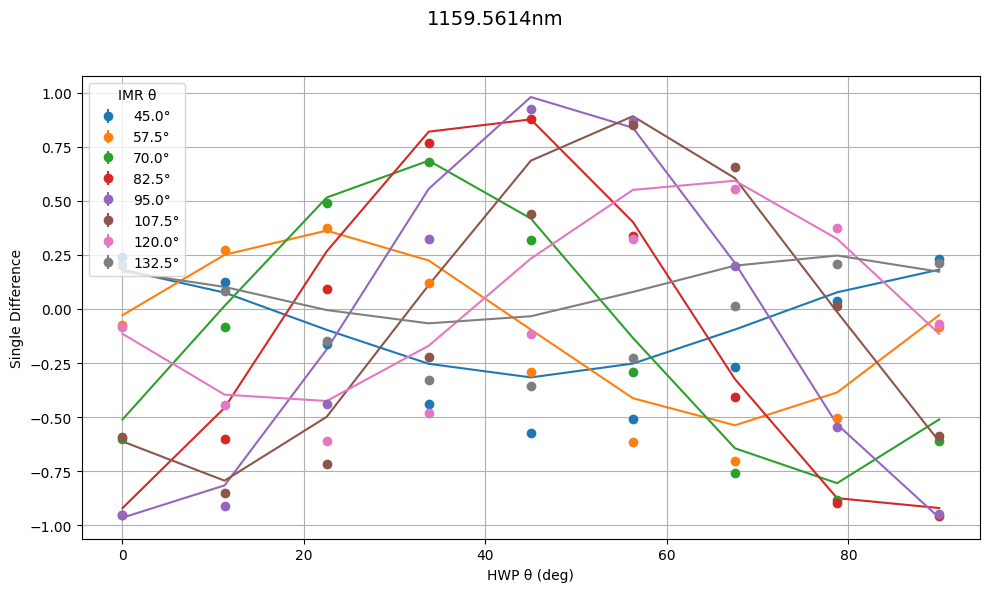

In [26]:

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins)[0], IMR_retardance(wavelength_bins)[0]]


# define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# plot the modeled and observed values

plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[0], mode='CHARIS')




In [27]:
# find residuals
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())

Residuals range: -0.34850937187899333 0.05915823439866466


Creating dictionary of p0 starting guesses

In [36]:
p0 = {
        "image_rotator" : 
            {"phi": IMR_retardance(wavelength_bins)[0], "delta_theta": offset_imr},
        "hwp" :  
            {"phi": HWP_retardance(wavelength_bins)[0], "delta_theta": offset_hwp},
        "lp" : 
            {"delta_theta": offset_cal }
}
    

p0_values, p0_keywords = parse_configuration(p0)
print(p0)

{'image_rotator': {'phi': 4.530154810514752, 'delta_theta': -0.0118}, 'hwp': {'phi': 3.001856927823014, 'delta_theta': -0.002}, 'lp': {'delta_theta': -0.035}}


Minimize

In [29]:
# Define some bounds

hwp_phi_bounds = (0.9*(HWP_retardance(wavelength_bins)[0])), (1.1*(HWP_retardance(wavelength_bins)[0]))
imr_phi_bounds = (0.9*(IMR_retardance(wavelength_bins)[0])), (1.1*(IMR_retardance(wavelength_bins)[0]))
offset_imr_bounds = (1.1*offset_imr, 0.9*offset_imr)
offset_hwp_bounds = (1.1*offset_hwp, 0.9*offset_hwp)
offset_cal_bounds = (1.1*offset_cal, 0.9*offset_cal)

# Minimize the system Mueller matrix using the interleaved values and standard deviations

result, logl_result = minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
    interleaved_stds, configuration_list, bounds = [imr_phi_bounds, offset_imr_bounds,hwp_phi_bounds, offset_hwp_bounds, offset_cal_bounds],mode='CHARIS')
print(result)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 6375645.390952509
       x: [ 4.364e+00 -1.067e-02  3.029e+00 -2.142e-03 -3.156e-02]
     nit: 2
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-5.365e-04  3.673e-06 ... -4.595e-07  1.117e-05]]
    nfev: 95


Plot new model

Configurations List Length:  72


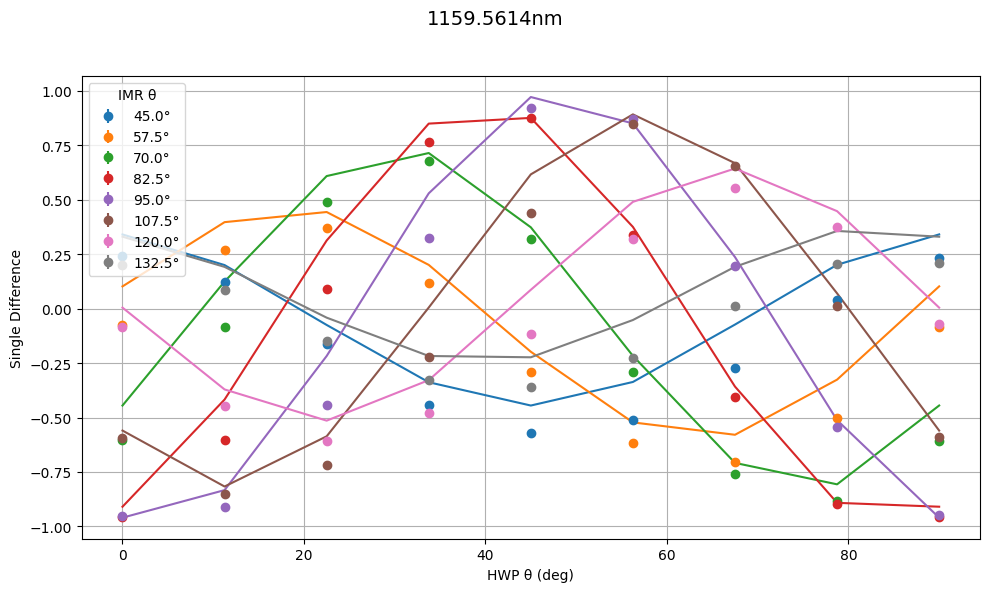

[[ 0.33266213  0.33266193 -0.00036644  0.        ]
 [-0.33266213 -0.33266193  0.00036644  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.2270761939927966 0.017899496705955698


In [30]:


print("Configurations List Length: ", len(configuration_list))

# update p dictionary with the new values

update_p0(p0, result.x)

# process model

p0_values, p0_keywords = parse_configuration(p0)

# update the system Mueller matrix with the new parameters

updated_system_mm = update_system_mm(result.x, p0_keywords, system_mm)

# generate our modeled left and right beam intensities

LR_intensities2 = model(p0_values, p0_keywords, updated_system_mm, configuration_list)

# process these into interleaved single norm differences and sums

diffs_sums2 = process_model(LR_intensities2, 'CHARIS')

# plot the modeled and observed values

plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums2,configuration_list, wavelength= wavelength_bins[0], mode='CHARIS')

# print the Mueller matrix

print("Updated Mueller Matrix:", updated_system_mm.evaluate())

# find residuals

residuals = interleaved_values[::2] - diffs_sums2[::2]
print("Residuals range:", residuals.min(), residuals.max())

In [35]:
# save system dictionary to a json file
with open ('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/system_dicts_no_pickoff/bin0.json', 'w') as f:
    json.dump(p0, f, indent=4)

In [32]:
# redo all minimization functions

# define log likelihood

# def lnl(p, system_parameters, system_mm, single_differences, errors, configuration_list):
 #    """
  #   Calculate the log-likelihood for the given parameters.
   #  """
    # intensities = model(p, system_parameters, system_mm, configuration_list)
   #  model_values = (process_model(intensities, 'CHARIS'))
   #  residuals = single_differences - model_values
   #  chi_squared = np.sum((residuals / errors) ** 2)
   #  return 0.5 * chi_squared

# minimize

# minimize_result = minimize(lnl, p0_values, args=(p0_keywords, updated_system_mm, interleaved_values, interleaved_stds, configuration_list),
#                           bounds=[imr_phi_bounds, offset_imr_bounds, hwp_phi_bounds, offset_hwp_bounds, offset_cal_bounds],method='Powell')
# print("Minimized Parameters:", minimize_result)


In [33]:
# update_p0(p0, minimize_result.x)
# updated_system_mm = update_system_mm(minimize_result.x, p0_keywords, system_mm)
# model__ = model(minimize_result.x, p0_keywords, system_mm, configuration_list, )
# process model

# p0_values, p0_keywords = parse_configuration(p0)


# generate our modeled left and right beam intensities

# # LR_intensities2 = model(p0_values, p0_keywords, updated_system_mm, configuration_list)

# process these into interleaved single norm differences and sums

# diffs_sums2 = process_model(LR_intensities2, 'CHARIS')

# plot the modeled and observed values

# plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums2,configuration_list, wavelength= wavelength_bins[0], mode='CHARIS')

# residuals_powell = interleaved_values[::2] - diffs_sums2[::2]
# print(residuals_powell.min(), residuals_powell.max())

In [41]:
# streamline process for all wavelength bins

def fit_CHARIS_Mueller_matrix_by_bin(csv_path, wavelength_bin, new_system_dict_path,plot_path=None):
    """
    Fits a Mueller matrix for one wavelength bin from internal calibration data and saves
    the updated system dictionary to a JSON file. Creates a plot
    of each updated model vs the data. Initial guesses for all fits are from Joost t Hart 2021.
    Note that following the most recent model update these guesses should be updated.
    The csv containing the calibration data and relevant headers can be obtained by 
    the write_fits_info_to_csv function in instruments.py. This code currently fits for
    derotator retardance/offset, HWP retardance/offset, and calibration polarizer offset.
    It can be modified relatively easily to fit for other parameters as well. 

    Parameters
    ----------
    csv_path : str or Path
        Path to the CSV file containing the calibration data. Must contain the columns "D_IMRANG", 
    "RET-ANG1", "single_sum", "norm_single_diff", "diff_std", and "sum_std".

    wavelength_bin : int
        The index of the wavelength bin to fit (0-21 for CHARIS).

    new_system_dict_path : str or Path
        Path to save the new system dictionary as a JSON file.

    plot_path : str or Path, optional
        Path to save the plot of the observed vs modeled data. If not provided, no plot will be saved.
        Must have a .png extension.
    
    Returns
    -------
    None
        The function saves the updated system dictionary to a JSON file and optionally saves a plot of the observed vs modeled data.
    """
    # Check file paths
    filepath = Path(csv_path)
    if not filepath.exists() or filepath.suffix != ".csv":
        raise ValueError("Please provide a valid .csv file.")
    plot_path = Path(plot_path)
    if plot_path.suffix != ".png":
        raise ValueError("Please provide a valid .png file for plotting.")
    if new_system_dict_path.suffix != ".json":
        raise ValueError("Please provide a valid .json file for saving the new system dictionary.")
    new_system_dict_path = Path(new_system_dict_path)
    # Read in data

    interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)

    # Loading in past fits from Joost t Hart 2021

    offset_imr = -0.0118 # derotator offset
    offset_hwp = -0.002 # HWP offset
    offset_cal = -0.035 # calibration polarizer offset
    imr_theta = 0 # placeholder 
    hwp_theta = 0 # also placeholder
    imr_phi = IMR_retardance(wavelength_bins)[wavelength_bin]
    hwp_phi = HWP_retardance(wavelength_bins)[wavelength_bin]

    # Define instrument configuration as system dictionary
    # Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o'}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "general_linear_polarizer_function_with_theta",
                    "properties": {"delta_theta": offset_cal },
                    "tag": "internal",
                }}
        }

    # Converting system dictionary into system Mueller Matrix object

    system_mm = generate_system_mueller_matrix(system_dict)

    # Define initial guesses for our parameters 
    # Modify this if you want to change the parameters

    p0 = {
        "image_rotator" : 
            {"phi": IMR_retardance(wavelength_bins)[wavelength_bin], "delta_theta": offset_imr},
        "hwp" :  
            {"phi": HWP_retardance(wavelength_bins)[wavelength_bin], "delta_theta": offset_hwp},
        "lp" : 
            {"delta_theta": offset_cal }
    }

    # Define some bounds
    # Modify this if you want to change the parameters or minimization bounds

    hwp_phi_bounds = (0.9*hwp_phi, 1.1*hwp_phi)
    imr_phi_bounds = (0.9*imr_phi, 1.1*imr_phi)
    offset_imr_bounds = (1.1*offset_imr, 0.9*offset_imr)
    offset_hwp_bounds = (1.1*offset_hwp, 0.9*offset_hwp)
    offset_cal_bounds = (1.1*offset_cal, 0.9*offset_cal)

    # Minimize the system Mueller matrix using the interleaved values and standard deviations
    # Modify this if you want to change the parameters

    result, logl_result = minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
        interleaved_stds, configuration_list, bounds = [imr_phi_bounds, offset_imr_bounds,hwp_phi_bounds, offset_hwp_bounds, offset_cal_bounds],mode='CHARIS')
    print(result)

    # Update p dictionary with the fitted values

    update_p0(p0, result.x)

    # Process model

    p0_values, p0_keywords = parse_configuration(p0)

    # Generate modeled left and right beam intensities

    updated_system_mm = update_system_mm(result.x, p0_keywords, system_mm)

    # Generate modeled left and right beam intensities

    LR_intensities2 = model(p0_values, p0_keywords, updated_system_mm, configuration_list)

    # Process these into interleaved single normalized differences and sums

    diffs_sums2 = process_model(LR_intensities2, 'CHARIS')

    # Plot the modeled and observed values

    plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums2,configuration_list, wavelength= wavelength_bins[0], mode='CHARIS',save_path=plot_path)

    # Print the Mueller matrix

    print("Updated Mueller Matrix:")
    print(updated_system_mm.evaluate())

    # Print residuals

    residuals = interleaved_values[::2] - diffs_sums2[::2]
    print("Residuals range:", residuals.min(), residuals.max())

    # Save system dictionary to a json file

    with open (new_system_dict_path, 'w') as f:
        json.dump(p0, f, indent=4)





 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 6375645.390952509
       x: [ 4.364e+00 -1.067e-02  3.029e+00 -2.142e-03 -3.156e-02]
     nit: 2
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-5.365e-04  3.673e-06 ... -4.595e-07  1.117e-05]]
    nfev: 95


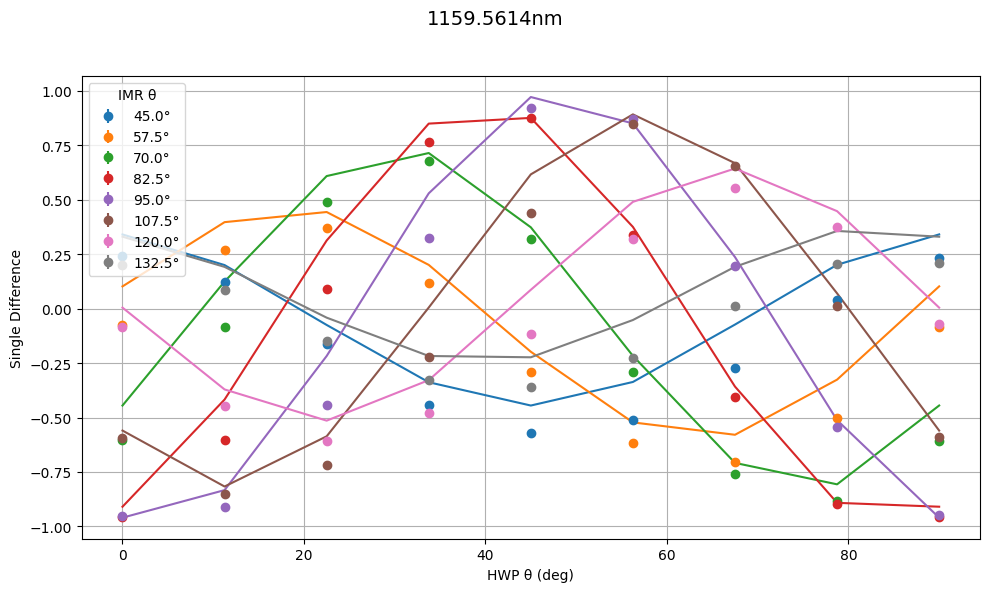

Updated Mueller Matrix:
[[ 0.33266213  0.33266193 -0.00036644  0.        ]
 [-0.33266213 -0.33266193  0.00036644  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.2270761939927966 0.017899496705955698


In [44]:
# retry with streamlined func

fit_CHARIS_Mueller_matrix_by_bin(filepath, 0, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/system_dicts_no_pickoff/bin0_2.json'),
    plot_path=Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_plots_no_pickoff/bin0_2.png'))